# 주식 예측 도오오~ ~전📈

# STEP 1 : 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath)

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
1,2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2,2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
3,2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
4,2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

여기서 우리는 **종가(Close)**만 사용하겠습니다!!

In [3]:
ts = df['Close']

ts.head()

0    48800.0
1    50300.0
2    50000.0
3    49950.0
4    48750.0
Name: Close, dtype: float64

# STEP 2 : 각종 전처리 수행
## 1. 결측치 처리

In [4]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

만약 결측치가 있다면?

1. 결측치 데이터 모두 삭제(drop)
2. 결측치 보간(interpolation)

시계열 데이터이기때문에 삭제보다는 **보간**

> ts=ts.interpolate(method='time')

## 2. 로그 변환
시간 추이에 따라 분산이 점점 커질 경우 **로그 변환**을 해주면 **시간 추이에 따른 분산이 일정**해집니다. 

In [5]:
ts_log = np.log(ts)

# STEP 3 : 시계열 안정성 분석
## 1. 정성적 그래프 분석
**구간 통계치(rolling statistics)**를 시각화해봅니다.
>1. 구간의 평균(rolling mean, 이동평균)
2. 표준편차(rolling std, 이동표준편차)

In [6]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    
    orig = plt.plot(timeseries,color='blue',label='original')
    mean = plt.plot(rolmean,color='red',label='rolling mean')
    std = plt.plot(rolstd,color='black',label='rolling std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

* plt.legend(loc='best') :최적의 위치에 레전드 위치시킴
* plt.show(block=False) : figure창 자동으로 닫기

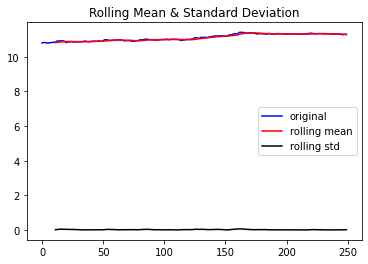

In [7]:
plot_rolling_statistics(ts_log, window=12)

## 2. 정량적 Augmented Dicky-Fuller Test
statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 ADF 검정을 수행하는 코드입니다.

In [8]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [9]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


**ts_log 시계열**의 p-value가 0에 가깝기 때문에 안정적이지 않다는 귀무가설은 기각되고, **안정적 시계열**이라는 대립가설이 채택됩니다. 

## 3. 시계열 분해(Time Series Decomposition)
statsmodels 라이브러리 안에는 **seasonal_decompose** 메서드를 통해 시계열 안에 존재하는 **trend, seasonality를 직접 분리**해 낼 수 있는 기능이 있습니다.

> Original = Trend+Seasonality+Residual

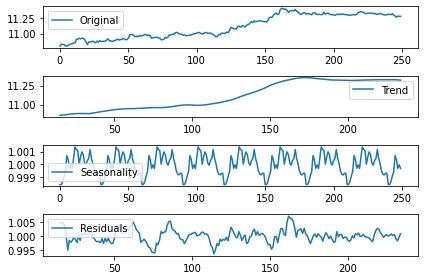

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 로그변환한 원본 - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## 4. Residual 안정성 확인

In [11]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Residual(잔차)에서의 p-value의 값이 0에 가까우므로 정상성 시계열로 볼 수있다. 

# STEP 4 : 학습, 테스트 데이터셋 생성
##  학습,테스트 데이터셋 분리
시계열 예측이니 **가장 나중 데이터를 테스트용으로 사용**하는 것이 타당하므로 학습과 테스트데이터를 9:1로 분리해주었습니다. 


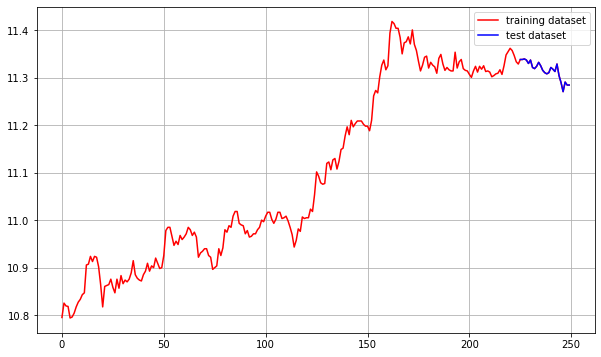

In [12]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# STEP 5 : 적정 ARIMA 모수 찾기

## 0.여기서 잠깐! ARIMA란 ?
ARIMA는 시계열 데이터 예측 모델을 자동으로 만들어줍니다.

* AR (자기회귀) -> Residual 모델링
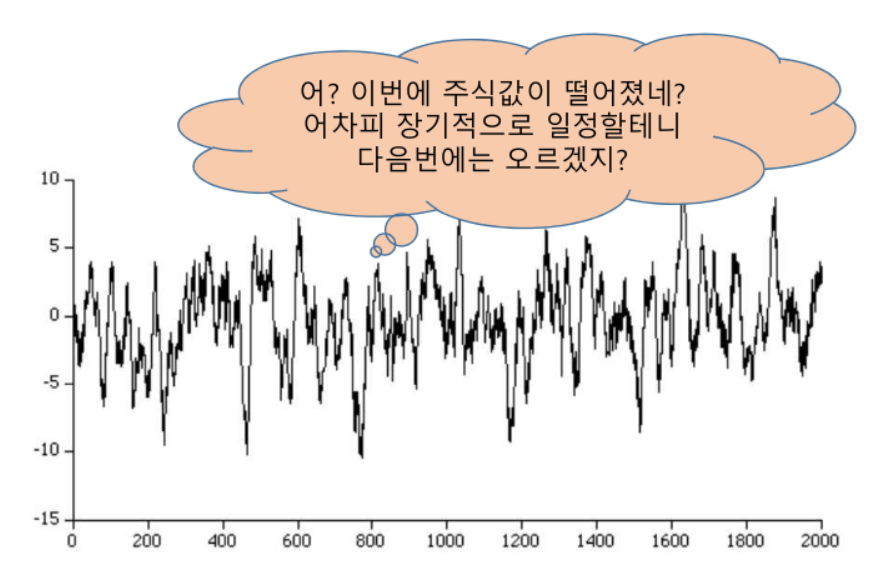

* MA (이동평균) -> Trend 모델링
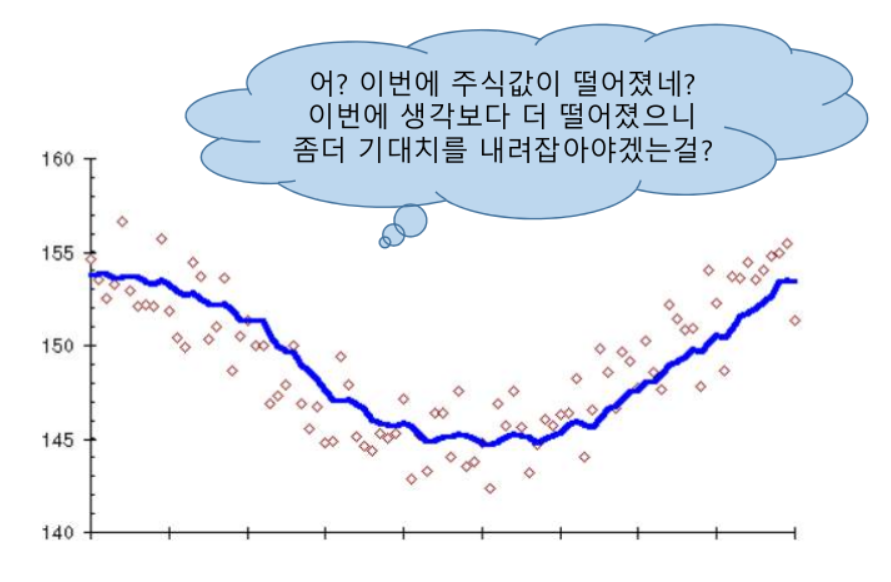

* I (차분누적) -> Seasonality 모델링

 


### 1) ARIMA의 모수 p,q,d
* p : 자기회귀 모형(AR)의 시차
* d : 차분 누적(I) 횟수
* q : 이동평균 모형(MA)의 시차

p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용하는데, 이는 p 나 q 중 하나는 0이라는 뜻입니다. 이렇게 하는 이유는 많은 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문입니다.

### 2) ARIMA의 모수 p,q,d를 결정하는 방법

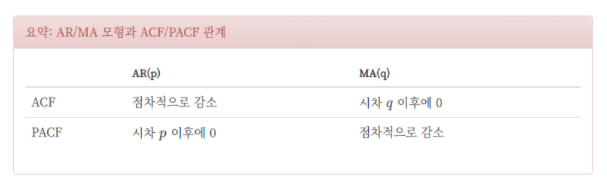
ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정합니다.

## 1. ACF, PACF 그려보기 -> p,q 구하기

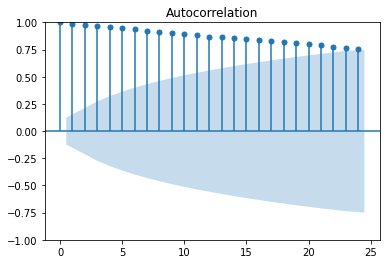

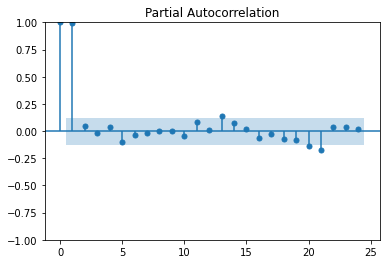

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF 그래프는 1에서 0.75로 점차적으로 감세하는 추세이고, PACF는 시차 p 이후에 모두 0입니다. 그래서 MA 모델을 고려하지않고 **AR 모델**을 사용합니다.

-> p=2, q=0

## 2. 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


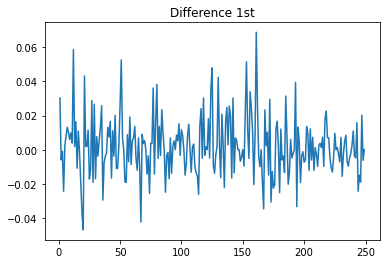

In [14]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


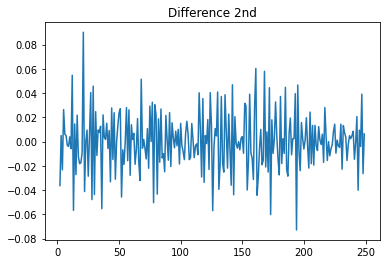

In [15]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

<AxesSubplot:>

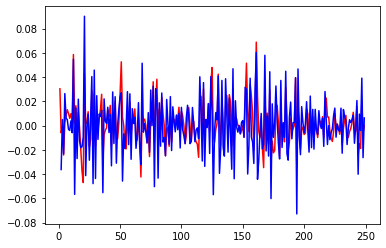

In [16]:
diff_1.plot(color='red')
diff_2.plot(color='blue')

1차 차분(red)이 평균과 분산이 더 일정해보입니다. 

-> d=1

# STEP 6 : ARIMA 모델 훈련과 테스트
## 1. ARIMA 모델 빌드와 훈련

In [17]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Tue, 15 Feb 2022   AIC                          -1156.722
Time:                        09:47:14   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

## 2. 모델 테스트 및 플로팅

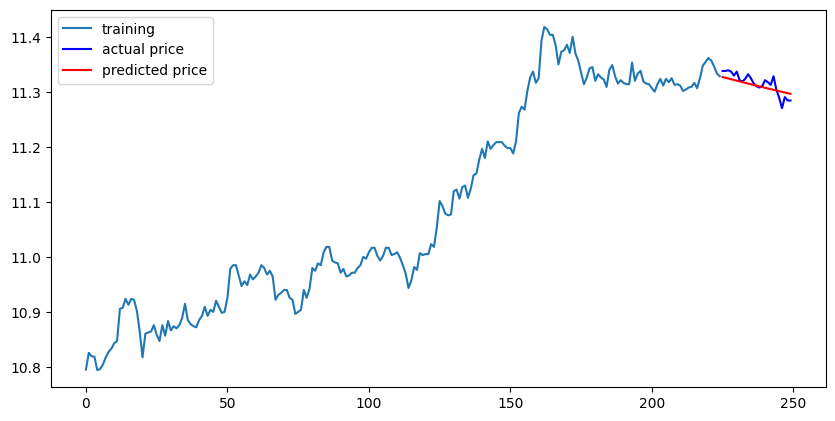

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

## 3.최종 예측 모델 정확도 측정(MAPE)

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# STEP 7 : 다른 주식 종목 예측해 보기
## META
최근 주식이 폭락한 META(페이스북)를 예측해보겠습니다. 새로운 기술들을 도입하고 있는 듯 한데 폭락해서 안타깝네요...😓
### 1. 시계열 데이터 준비

In [20]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/FB.csv'
df = pd.read_csv(dataset_filepath)
ts = df['Close']

ts.head()

0    271.869995
1    270.390015
2    270.500000
3    273.970001
4    273.570007
Name: Close, dtype: float64

### 2. 전처리

In [21]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [22]:
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

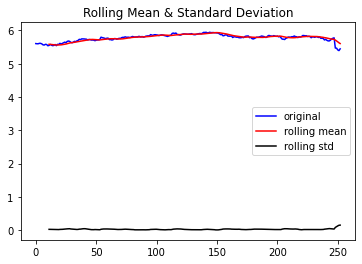

In [23]:
plot_rolling_statistics(ts_log, window=12)

In [24]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.708809
p-value                          0.844455
#Lags Used                       4.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


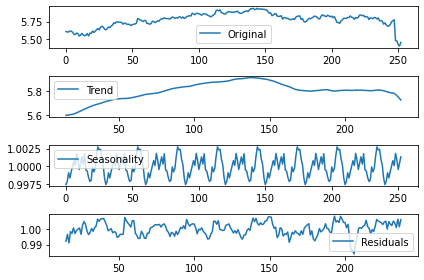

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 로그변환한 원본 - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [26]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.436641
p-value                          0.000003
#Lags Used                       5.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


### 4. 학습,테스트 데이터셋 생성

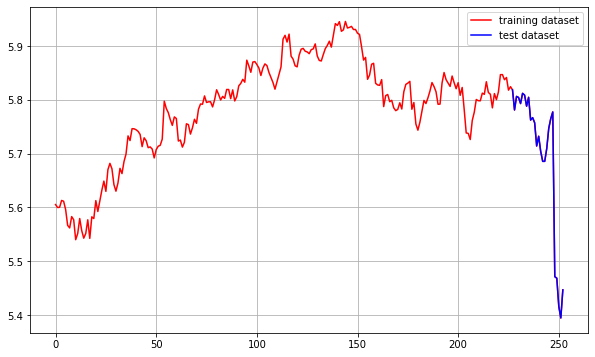

In [27]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

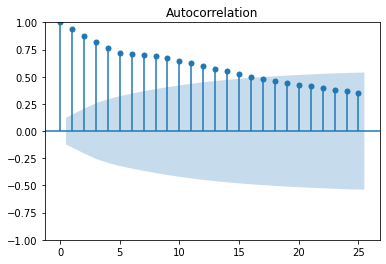

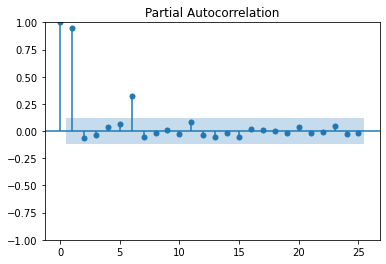

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -9.223173e+00
p-value                        1.757534e-15
#Lags Used                     3.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.513381e+00
p-value                        3.961224e-11
#Lags Used                     1.300000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


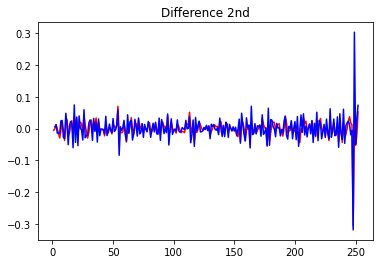

In [29]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st',color='red')
augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd',color='blue')
augmented_dickey_fuller_test(diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [30]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 584.968
Date:                Tue, 15 Feb 2022   AIC                          -1159.936
Time:                        09:47:15   BIC                          -1142.811
Sample:                             0   HQIC                         -1153.026
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7599      0.056    102.776      0.000       5.650       5.870
ar.L1          0.7441      1.433      0.519      0.604      -2.065       3.553
ar.L2          0.2382      1.413      0.169      0.8

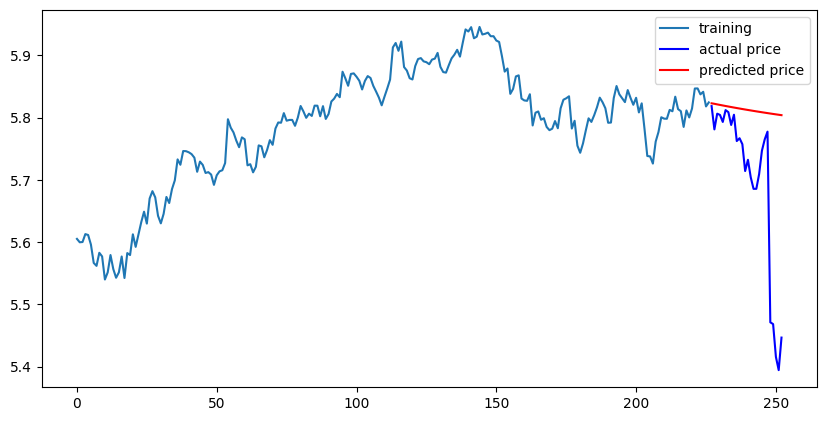

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2340.5705108121647
MAE:  32.99991364938085
RMSE:  48.379443060169315
MAPE: 12.87%


시계열 데이터 분석이 완벽한 미래 예측을 보장하지 않는다는 것을 보여줍니다.
예측하지 못한 외부적 변수에 의해 시계열 데이터 분석의 전제가 되는 **안정성이 훼손**되었네요...😅

## TSLA
혁신적인 기술을 해내고있는 테슬라의 주식도 예측해보겠습니다. 앞으로의 전망이 매우 기대가 되는군요 😁
### 1.  시계열 데이터 준비

In [33]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath)
ts = df['Close']

ts.head()

0    804.820007
1    811.659973
2    816.119995
3    796.219971
4    798.150024
Name: Close, dtype: float64

### 2. 전처리

In [34]:
df[df.isna()]

,Date,Open,High,Low,Close,Adj Close,Volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN
251,NaN,NaN,NaN,NaN,NaN,NaN,NaN


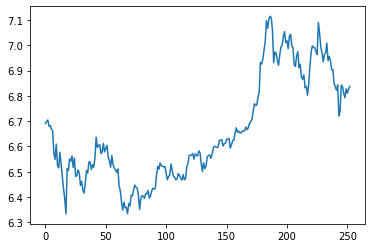

In [35]:
ts_log = np.log(ts)

plt.plot(ts_log)

### 3. 시계열 안정성 분석

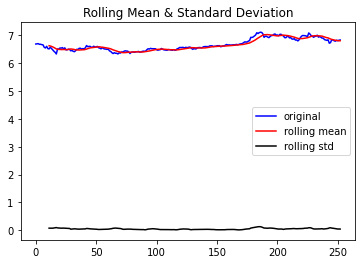

In [36]:
plot_rolling_statistics(ts_log, window=12)

In [37]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.228461
p-value                          0.661234
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


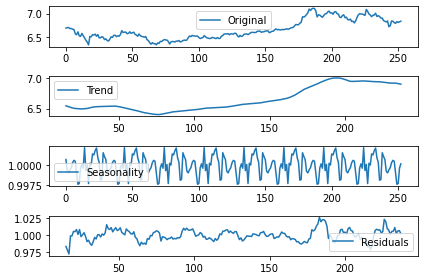

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 로그변환한 원본 - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [39]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.951004e+00
p-value                        2.147324e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


### 4. 학습, 테스트 데이터셋 생성

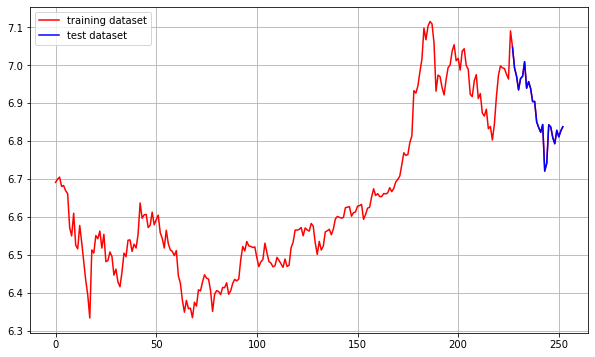

In [40]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

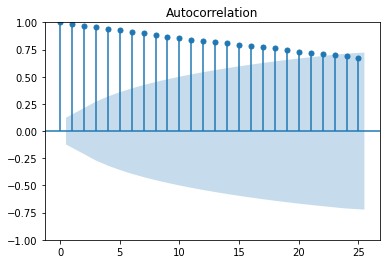

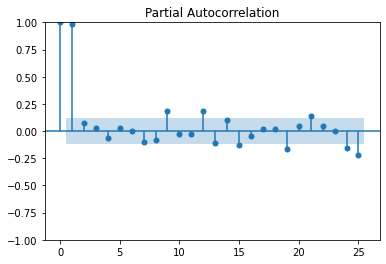

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.688748e+01
p-value                        1.051349e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.943489e+00
p-value                        1.011002e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


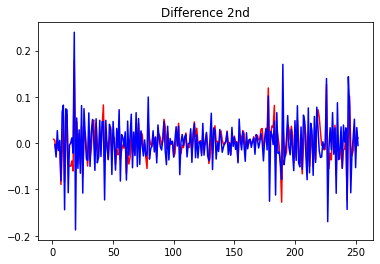

In [42]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st',color='red')
augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd',color='blue')
augmented_dickey_fuller_test(diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [43]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 439.894
Date:                Tue, 15 Feb 2022   AIC                           -869.787
Time:                        09:47:18   BIC                           -852.663
Sample:                             0   HQIC                          -862.877
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7461      0.210     32.065      0.000       6.334       7.158
ar.L1          0.4168      1.168      0.357      0.721      -1.872       2.705
ar.L2          0.5661      1.153      0.491      0.6

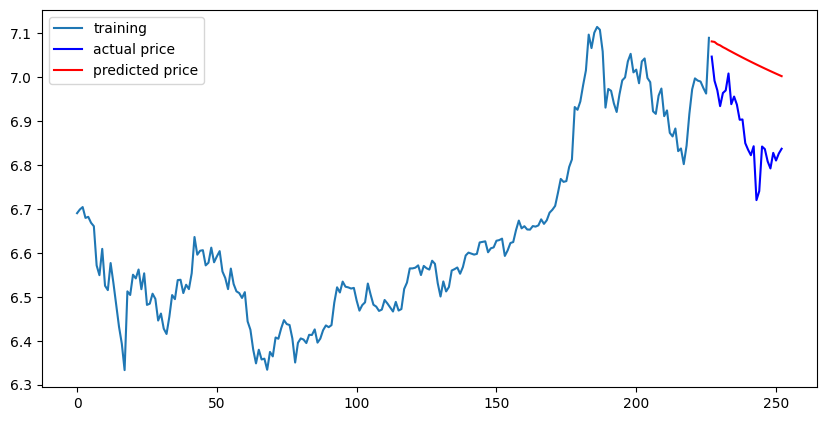

In [44]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  30898.462602270472
MAE:  165.5170851436495
RMSE:  175.7795852830199
MAPE: 17.54%


### 7. 오차율을 떨어뜨려보자 
#### 7.1 모수 변경 (d=2)

In [46]:
model = ARIMA(train_data, order=(2, 0, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 440.266
Date:                Tue, 15 Feb 2022   AIC                           -868.533
Time:                        09:47:18   BIC                           -847.983
Sample:                             0   HQIC                          -860.241
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7421      0.217     31.041      0.000       6.316       7.168
ar.L1          1.5386      0.851      1.807      0.071      -0.130       3.207
ar.L2         -0.5440      0.844     -0.645      0.5

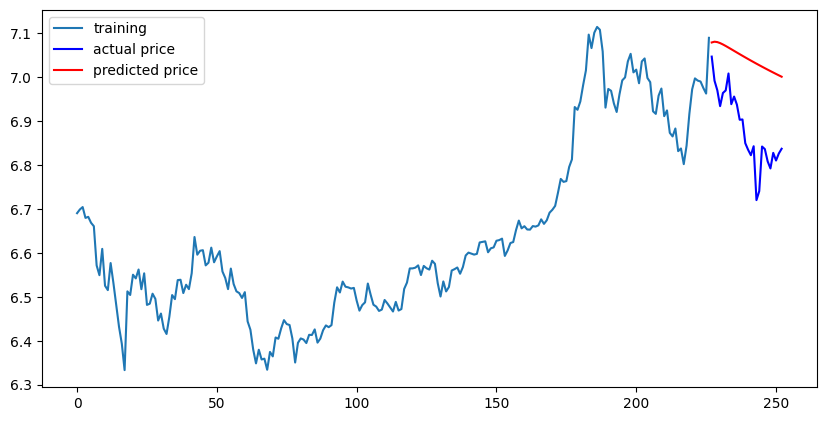

MSE:  31744.393443768404
MAE:  168.34555666704176
RMSE:  178.1695637413091
MAPE: 17.82%


In [47]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

차분을 늘리니 오차율이 더 높아졌다.

#### 7.2  훈련/테스트 비율 조절

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


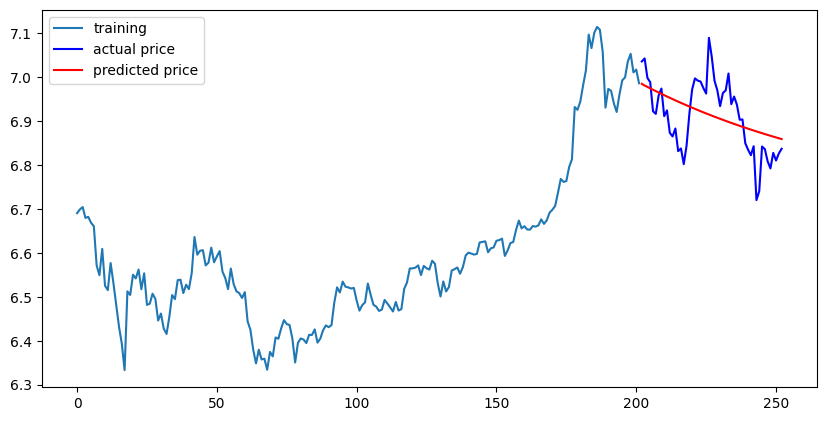

MSE:  5189.748275822951
MAE:  61.107632941867735
RMSE:  72.03990752230982
MAPE: 6.12%


In [48]:
train_data, test_data = ts_log[:int(len(ts_log)*0.8)], ts_log[int(len(ts_log)*0.8):]

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

오차율이 줄었으나 사실 아무런 의미가 없는 것 같다. 
데이터를 전처리하면서 의미있는 값을 도출할 수 있을거 같긴한데..

#### 7.3 seasonal_decompose 의 model 변경

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


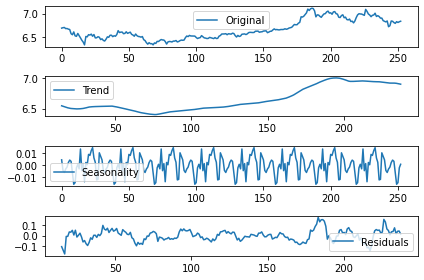

In [49]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

model = ARIMA(train_data, order=(3, 0, 1))  
fitted_m = model.fit() 

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='additive', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 로그변환한 원본 - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [50]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.002555e+00
p-value                        1.644165e-07
#Lags Used                     7.000000e+00
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


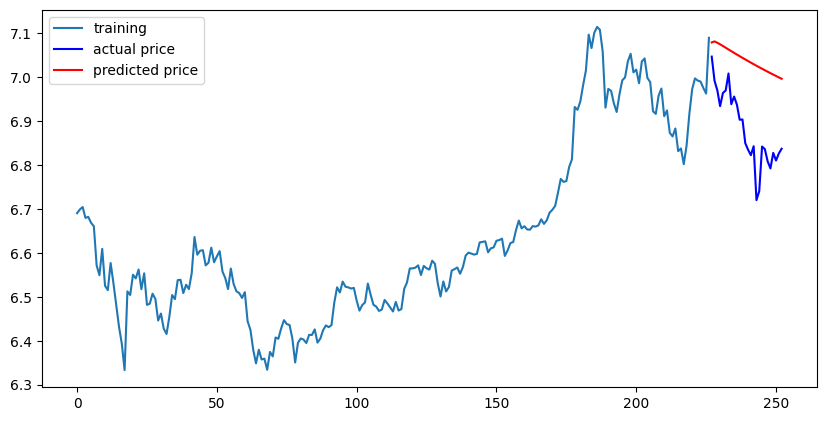

MSE:  30135.28007397744
MAE:  163.81283395626704
RMSE:  173.59516143596122
MAPE: 17.34%


In [51]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()


mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

## SBUX
저는 커피를 좋아합니다...☕❤
### 1. 시계열 데이터 준비

In [52]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/SBUX.csv'
df = pd.read_csv(dataset_filepath)
ts = df['Close']

ts.head()

0    106.150002
1    104.440002
2    104.970001
3    103.370003
4    101.809998
Name: Close, dtype: float64

### 2. 전처리

In [53]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [54]:
ts_log = np.log(ts)

### 3. 시계열 안정성 분석

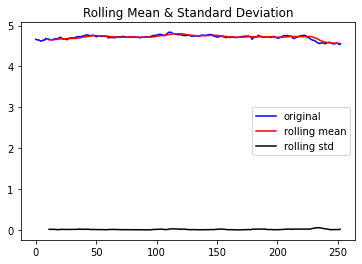

Results of Dickey-Fuller Test:
Test Statistic                  -0.814585
p-value                          0.814800
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


In [55]:
plot_rolling_statistics(ts_log, window=12)
augmented_dickey_fuller_test(ts_log)

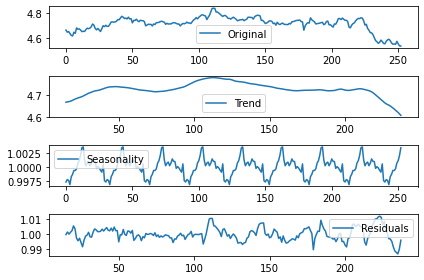

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 로그변환한 원본 - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [57]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.668257e+00
p-value                        9.046197e-07
#Lags Used                     2.000000e+00
Number of Observations Used    2.200000e+02
Critical Value (1%)           -3.460428e+00
Critical Value (5%)           -2.874769e+00
Critical Value (10%)          -2.573821e+00
dtype: float64


### 4. 학습,테스트 데이터셋 생성

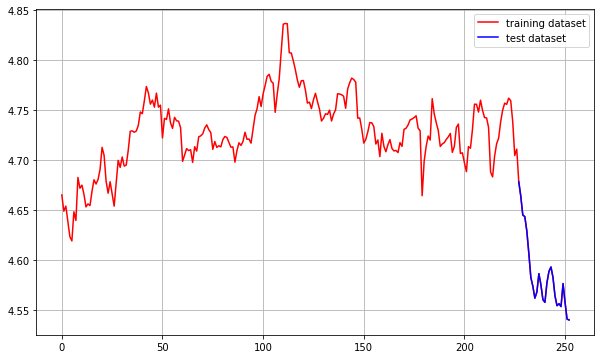

In [58]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 5. 적정 ARIMA 모수 찾기

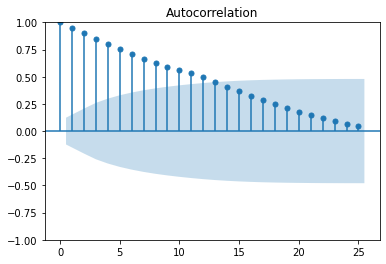

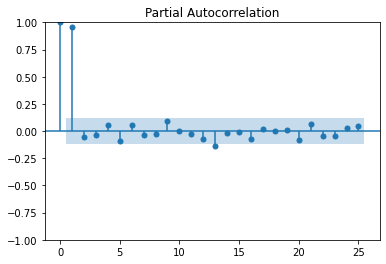

In [59]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 6. ARIMA 모델 훈련과 테스트

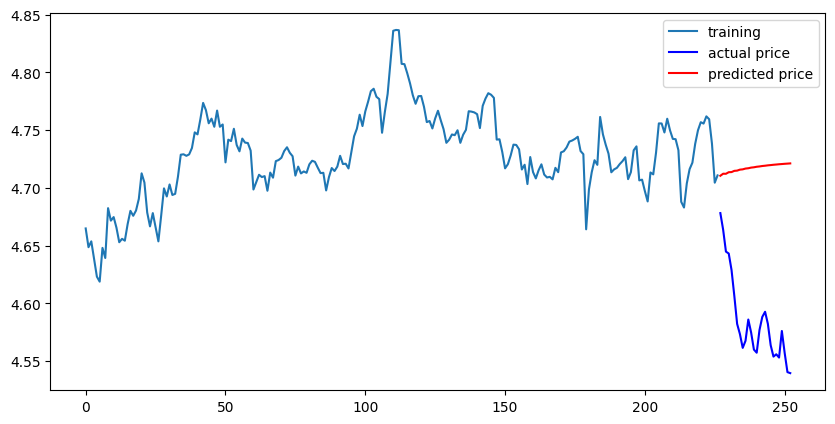

MSE:  206.56618088174815
MAE:  13.811473904779815
RMSE:  14.3724104061131
MAPE: 14.25%


In [60]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

# 회고

## 테슬라의 주가를 예측한 값이 15% 이하로 떨어뜨리기위해 했던 시도들
1. 원본데이터나 로그변환한 데이터나 별 차이가 없어서 원본 데이터로 넣었으나 별 차이가 없었다.
2. 훈련/ 테스트 비율을 조절하여 오차율을 떨어뜨렸으나 눈속임용이라고 생각되어 다른 방법을 또 시도하였다.
3. 1년치밖에 안뽑아와서 seasonal_decompose 의 model을 additive로 변경하였고, period도 30,60,90 등등 시도해보았으나 17.34%로 동일하였다. 

최적의 모수는 (3,0,1) 인듯하다. 최적의 모수를 자동으로 찾아주는 함수가 있다고한다.
예측 오류값을 줄이기위해 공부하다보니 기존 분해법보다 X11,STL 등등 더 좋은 분해법들이 있는 것을 알았다. 다음번엔 **STL 기법**을 통해 예측을 해보고싶다. (사실 시도는 해봤는데 자꾸 에러떠서 시간관계상 포기...ㅠㅠ)

<https://yoongaemii.github.io/seasonal_decomposition/>

시계열 데이터는 패턴에 따라 분석기법이 달라져서 fitting 하기에 앞서 EDA 과정을 거쳐 데이터의 특성을 파악하는 것이 중요하다고 생각한다. 하지만 처음 경험하기에 어떤 패턴에 어떤 기법을 써야 좋은건지 잘 모르겠어서 아쉬웠다. 
그리고 제일 재밌게 했던 exploration 이였다 ㅎㅎ
